In [50]:
import sys
import os
import io

# Add the parent directory to the sys.path
sys.path.append(os.path.join(os.getcwd(), '..'))

In [51]:
import glob
import csv

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import kurtosis, skew, rankdata
from scipy.signal import argrelextrema
from scipy.stats.kde import gaussian_kde

from rcv_learning.rcv_distribution import *
from rcv_learning.rcv_dimensionality import *

/var/folders/g2/25z774tn0599smwks8_v_k200000gp/T/ipykernel_88190/4019494009.py:10: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [52]:
def compute_ecdf(data):
    """Compute the empirical cumulative distribution function (ECDF) of data."""
    sorted_data = np.sort(data)
    n = len(data)
    return sorted_data, np.arange(1, n+1) / n

def dip_statistic(data):
    """Compute Hartigan's dip statistic for data."""
    data = np.sort(data)
    n = len(data)
    
    # Compute the empirical CDF
    x, ecdf = compute_ecdf(data)
    
    # Compute the greatest difference on the left and right side for each data point
    U = np.arange(1, n+1) / n
    D = U - np.arange(0, n) / n
    
    # Calculate the difference between the empirical distribution function and the 
    # unimodal distribution function that minimizes that maximum difference.
    low_dip = (ecdf - D).clip(min=0)
    up_dip = (U - ecdf).clip(min=0)
    both_dips = np.column_stack((low_dip, up_dip))
    
    # The dip statistic is the maximum difference over all data points
    dip = np.max(both_dips)
    
    return dip

In [53]:
# Search for CSV files in the directory and its subdirectories
csv_files = glob.glob("../rcv_elections_database/**/*.csv", recursive=True)

# Determine save behavior
save = True

# Dictionary to store all the consistency points across elections
election_consistency_points = {}

# Iterate over the CSV files
for file_path in csv_files:

    # Get the filename only
    filename = file_path.split('/')[-1]  
    print(file_path)

    try:
        csv = file_path
        filename_prefix = "plots/" + filename

        # Check if the plot already exists
        if os.path.isfile(f"{filename_prefix}_hist.png") and False: #! Shouldn't be False
            print("Skipping hist plot: {}".format(file_path))
            continue
            
        # Perform the RCV analysis
        test = perform_rcv_analysis(csv, n_runs=1000)
        mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

        # Print the normalized distances between candidates and plot the MDS analysis
        normalized_distances = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
        print("Normalized distances:", normalized_distances)
        plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names, save=save, filename=filename_prefix)

        # Get the consistency points for the bimodality analysis
        points = get_consistency_points(csv)
        print("Consistency points:", points)
        
        # Store the consistency points for later normalization and plotting
        election_consistency_points[filename] = points

        # Create a list of data points
        data_points = []
        for key, value in points.items():
            data_points.extend([key] * value)

        # Convert to numpy array
        data_points = np.array(data_points)

        # Calculate skewness and kurtosis
        g = skew(data_points)
        k = kurtosis(data_points)

        # Calculate KDE without plotting
        density = gaussian_kde(data_points)
        x_vals = np.linspace(min(data_points), max(data_points), 1000)
        y_vals = density(x_vals)

        # Identify local maxima in the KDE
        maxima_indices = argrelextrema(y_vals, np.greater)

        # Get the x-values of the maxima
        modes = x_vals[maxima_indices]

        # Check if there are at least two modes
        if len(modes) >= 2:
            mode1, mode2 = modes[:2]

            # Calculate the amplitudes of the two modes
            amp1 = density(mode1)[0]
            amp2 = density(mode2)[0]

            # Calculate the amplitude ratio with higher amplitude as denominator
            if amp1 > amp2:
                amplitude_ratio = amp2 / amp1
            else:
                amplitude_ratio = amp1 / amp2

            # Calculate x-axis distance between the two modes
            mode_distance = abs(mode2 - mode1)

        else:
            mode1, mode2 = None, None
            amplitude_ratio = None
            mode_distance = None

        try:
            # Split the data into two groups based on proximity to the modes
            data_group1 = [point for point in data_points if abs(point - mode1) < abs(point - mode2)]
            data_group2 = [point for point in data_points if abs(point - mode1) > abs(point - mode2)]

            # Display mean and variance for each group
            mu1, sigma1_sq = np.mean(data_group1), np.var(data_group1)
            mu2, sigma2_sq = np.mean(data_group2), np.var(data_group2)

            # Calculate Ashman's D statistic (D > 2)
            ashmans_D = abs(mu1 - mu2) / np.sqrt((sigma1_sq + sigma2_sq) / 2)

        except:
            mode_distance = 404
            amplitude_ratio = 404
            ashmans_D = 404

        # Calculate Sarle's bimodality coefficient b (b > 5/9)
        n = len(data_points)
        sarle = (g**2 + 1) / (k + 3 * (n-1)**2 / ((n-2) * (n-3)))

        # Calculate Hartigan's dip statistic (calculate p value)
        hartigan_dip = dip_statistic(data_points)

        # Prepare data for histogram
        data_list = [x for x, count in points.items() for _ in range(count)]
        normalized_points = []
        normalized_names = []
        for name in normalized_distances:
            normalized_names.append(name)
            normalized_points.append(normalized_distances[name])

        # Plot histogram
        plt.figure(figsize=(10, 6))
        plt.hist(data_list, bins=50, density=True, alpha=0.7)
        plt.title('Histogram of Data')
        plt.xticks(normalized_points, normalized_names, rotation=45)
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.grid(True)

        # Display measures in a text box
        text_str = f"Skewness: {g:.2f}\nKurtosis: {k:.2f}\nMode Distance: {mode_distance:.2f}"
        plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        if save:
            plt.savefig(f"{filename_prefix}_hist.png", bbox_inches='tight')
            plt.close()
        else:
            plt.show()

        # Plot kernal density estimation
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data_list, fill=True)
        plt.title('Kernel Density Estimation of Data')
        plt.xticks(normalized_points, normalized_names, rotation=45)
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.grid(True)

        # Display bimodality measures in a text box
        text_str = f"Ashman's D: {ashmans_D:.10f}\nSarle's Coefficient: {sarle:.10f}\nHartigan's Dip: {hartigan_dip:.10f}\nAmplitude Ratio: {amplitude_ratio:.10f}"
        plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        if save:
            plt.savefig(f"{filename_prefix}_kde.png", bbox_inches='tight')
            plt.close()
        else:
            plt.show()

    except Exception as e:
        print("Error in file: {}".format(file_path))
        print(e)

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:177: RuntimeWarning: invalid value encountered in divide
  frequencies = counts / mentioned_together


../rcv_elections_database/CandidateDetails.csv
Error in file: ../rcv_elections_database/CandidateDetails.csv
zero-size array to reduction operation minimum which has no identity
../rcv_elections_database/SingleWinnerRCV.csv
Error in file: ../rcv_elections_database/SingleWinnerRCV.csv
zero-size array to reduction operation minimum which has no identity
../rcv_elections_database/MatchedElections.csv
Error in file: ../rcv_elections_database/MatchedElections.csv
zero-size array to reduction operation minimum which has no identity
../rcv_elections_database/SequentialRCV.csv
Error in file: ../rcv_elections_database/SequentialRCV.csv
zero-size array to reduction operation minimum which has no identity
../rcv_elections_database/ProportionalRCV.csv
Error in file: ../rcv_elections_database/ProportionalRCV.csv
zero-size array to reduction operation minimum which has no identity
../rcv_elections_database/proportional/Minneapolis_11072017_BoardofEstimateandTaxation.csv


/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:188: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'John Edwards': 0.0, 'David B. Wheeler': 1.0510943863794195, 'Carol Becker': 2.0}


/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:188: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Consistency points: {1.0510943863794195: 7191, 2.0: 17436, 1.2883207897845645: 11544, 0.2627735965948549: 648, 0.5: 62, 0.38138679829742744: 147, 0.0: 598, 1.1569339914871373: 37}
../rcv_elections_database/proportional/Minneapolis_11072017_ParkBoardAtLarge.csv


/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:177: RuntimeWarning: divide by zero encountered in divide
  frequencies = counts / mentioned_together
/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:188: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'Jonathan Honerbrink': 0.0, 'Bob Sullentrop': 0.0004765953151738429, 'Meg Forney': 2.9823665539809308, 'Devin Hogan': 2.983818888064226, 'Russ Henry': 2.9850387126863236, 'Mike Derus': 2.986228472387964, 'Londel French': 2.9875811009669366, 'Latrisha Vetaw': 2.98782083945862, 'Charlie Casserly': 2.989030793769531, 'Scott Vreeland': 9.0}


/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:177: RuntimeWarning: divide by zero encountered in divide
  frequencies = counts / mentioned_together
/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:188: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Consistency points: {6.014948444934124: 784, 6.01763344601907: 5473, 6.0135427319108015: 1523, 6.0122390951643: 763, 6.012725972271748: 87, 6.010969206230469: 1078, 6.0124188990330625: 2244, 6.01215252637674: 260, 6.011301662119657: 31, 6.016181111935774: 1029, 6.012179160541379: 3341, 6.013027170312215: 307, 6.013208712072627: 318, 6.013771527612036: 2957, 6.013179648389977: 151, 6.7632250845143025: 76, 6.014068967537446: 142, 9.0: 717, 6.013054496103216: 291, 6.012577252309043: 177, 6.014737007213794: 836, 6.016544195456598: 121, 6.012874692234453: 286, 6.013206974180978: 1461, 6.014961287313676: 1396, 6.01338851594139: 172, 6.01263526617762: 142, 6.0143867170410985: 329, 6.014918477622664: 329, 6.015311528454948: 167, 6.013899888965074: 79, 6.015629326990025: 232, 6.016043951532298: 126, 6.015281561143487: 232, 6.011271694808197: 33, 6.01335945225874: 220, 6.013540994019152: 135, 6.012301246339446: 46, 6.013869921653614: 100, 6.013722535779564: 334, 6.012905776140511: 75, 6.01336119

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:188: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'Reeves, Kenneth E.': 0.0, 'Simmons, E. Denise': 0.1423890948982111, 'Seidel, Sam': 0.5007777720279604, 'Toomey, Jr., Timothy J.': 2.057874267773084, 'Davis, Henrietta': 2.209432512327003, 'Decker, Marjorie C.': 3.0170903583451585, 'Maher, David P.': 3.4395512174299423, 'Kelley, Craig A.': 4.359128791444049, 'Cheung, Leland': 4.5949207970841455, 'vanBeuzekom, Minka Y.': 5.7784812494612945, 'Ward, Larry W.': 6.220518497871661, 'Stohlman, Jr., Thomas J.': 7.296574009268365, 'Marquardt, Charles J.': 8.71528128288753, 'Nelson, Matthew P.': 10.141419565095722, 'Pascual, Jamake': 11.40313256726831, 'Mello, Gary W.': 13.956577920546108, 'Moree, Gregg J.': 16.657702574529722, 'Williamson, James M.': 17.0}


/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:188: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Consistency points: {1.5203289203201902: 5, 0.8245092060967896: 10, 5.432293232151878: 51, 2.4981055608465383: 23, 0.8725895642922324: 1, 0.6783819351744841: 21, 1.0182276216062267: 5, 2.819771080343239: 5, 2.3852211460321797: 178, 0.30427189278499284: 138, 4.180389418695796: 29, 2.0086285915456785: 94, 2.0496669158788983: 17, 14.202656254119663: 13, 4.615420075464683: 21, 0.0: 71, 1.8553180227058454: 4, 2.262718343340266: 2, 1.8830977400501783: 354, 4.502745302090354: 4, 4.343129023235618: 124, 5.339579923054051: 4, 1.9135658715636907: 11, 4.295866390123811: 1, 3.2486846806661065: 16, 8.134865355719809: 63, 5.839075284567886: 100, 5.675421041870933: 1, 2.0907052402121176: 13, 3.3231152552205447: 2, 4.212997878484879: 2, 4.65058962793382: 2, 4.07252894756023: 9, 1.8112753606375305: 10, 7.464882711238844: 1, 3.4460396439675858: 14, 2.8545736304886704: 55, 1.292171055849716: 1, 2.752738935328617: 2, 2.922061591269399: 8, 12.958136270682557: 19, 4.0910732070821885: 1, 0.7890473834450101: 

/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:188: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'Kevin Nikiforakis': 0.0, 'Steve Brandt': 1.5723092375760337, 'Samantha "Sam" Pree-Stinson': 2.05015975695978, 'Pine Salica': 3.0}


/Users/es5891/Documents/GitHub/bugs-in-democracy/rcv_exploration/../rcv_learning/rcv_dimensionality.py:188: RuntimeWarning: divide by zero encountered in divide
  distance = 1 / np.sqrt(freq_upper_triangle)


KeyboardInterrupt: 

In [ ]:
import pickle

# Specify the filename for the pickle file
pickle_filename = "election_consistency_points.pkl"

# Open the file in write-binary mode and dump the dictionary
with open(pickle_filename, 'wb') as f:
    pickle.dump(election_consistency_points, f)

In [8]:
import pickle

# Specify the filename for the pickle file
pickle_filename = "election_consistency_points.pkl"

# Open the pickle file in read-binary mode and load the dictionary
with open(pickle_filename, 'rb') as f:
    election_consistency_points = pickle.load(f)

In [9]:
import pandas as pd

def filter_elections(filter_criteria):
    """Filter the elections based on the given criteria."""
    election_df = pd.read_csv("election_table.csv")
    
    # Apply the filters
    for key, value in filter_criteria.items():
        if isinstance(value, list):  # Check if the filter value is a list
            election_df = election_df[election_df[key].isin(value)]  # Use .isin() for lists
        else:
            election_df = election_df[election_df[key] == value]
    
    filtered_elections = election_df['filename'].tolist()
    election_list = [election_consistency_points[election] for election in filtered_elections if election in election_consistency_points]
    for election in filtered_elections:
        print(election)
    
    return election_list

In [10]:
from scipy.stats import gaussian_kde
import numpy as np

def compute_kdes(points_list):
    """Compute KDE for each election."""
    
    kdes = []
    x_grid = np.linspace(0, 1, 500)  # Define a grid to evaluate the KDEs
    
    # Normalize and compute KDE for each election
    for points in points_list:
        # Normalize x-values
        abs_max_x = max(abs(min(points.keys())), abs(max(points.keys())))
        normalized_data = [(x + abs_max_x) / (2 * abs_max_x) for x in points.keys()]
        
        # Compute KDE and evaluate it on the x_grid
        kde = gaussian_kde(normalized_data)
        kde_values = kde(x_grid)
        
        kdes.append(kde_values)
    
    return kdes, x_grid

In [11]:
import matplotlib.pyplot as plt

def plot_kdes(kdes, x_grid, title="KDE Analysis"):
    """Plot the computed KDEs."""
    
    plt.figure(figsize=(10, 6))
    
    for kde_values in kdes:
        plt.plot(x_grid, kde_values)
    
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

Alaska_08162022_HouseofRepresentativesSpecial.csv
Alaska_11082022_USRepresentative.csv
Maine_11062018_CongressionalDistrict2.csv
Maine_11082022_CongressionalDistrict2.csv
Alaska_11082022_USSenator.csv
Alaska_11082022_GovernorLieutenantGovernor.csv
Alaska_11082022_HouseDistrict1.csv
Alaska_11082022_HouseDistrict2.csv
Alaska_11082022_HouseDistrict4.csv
Alaska_11082022_HouseDistrict5.csv
Alaska_11082022_HouseDistrict6.csv
Alaska_11082022_HouseDistrict7.csv
Alaska_11082022_HouseDistrict9.csv
Alaska_11082022_HouseDistrict10.csv
Alaska_11082022_HouseDistrict11.csv
Alaska_11082022_HouseDistrict12.csv
Alaska_11082022_HouseDistrict13.csv
Alaska_11082022_HouseDistrict14.csv
Alaska_11082022_HouseDistrict15.csv
Alaska_11082022_HouseDistrict16.csv
Alaska_11082022_HouseDistrict17.csv
Alaska_11082022_HouseDistrict18.csv
Alaska_11082022_HouseDistrict19.csv
Alaska_11082022_HouseDistrict20.csv
Alaska_11082022_HouseDistrict21.csv
Alaska_11082022_HouseDistrict22.csv
Alaska_11082022_HouseDistrict23.csv
Ala

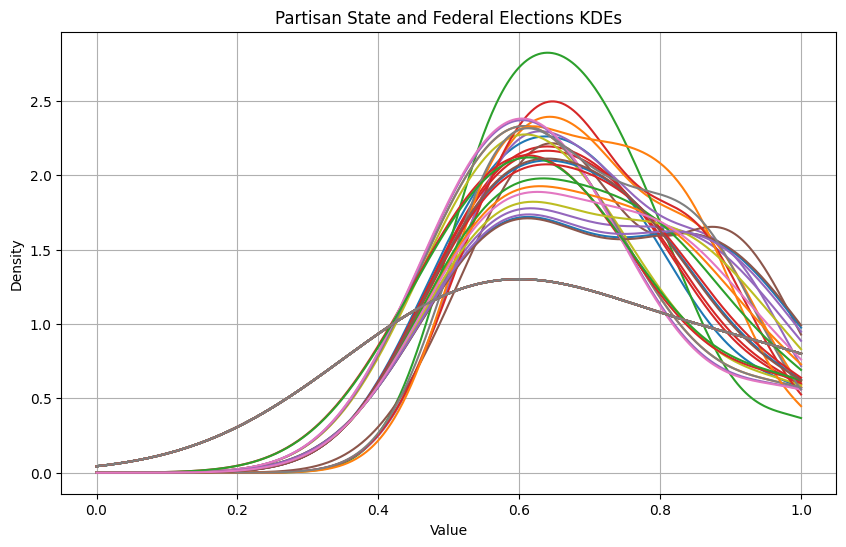

Albany_11082022_BoardofEducation.csv
Minneapolis_11022021_ParkBoardAtLarge.csv
Minneapolis_11022021_ParkBoardDistrict2.csv
Minneapolis_11022021_ParkBoardDistrict3.csv
Minneapolis_11022021_ParkBoardDistrict4.csv
Minneapolis_11022021_ParkBoardDistrict5.csv
Minneapolis_11022021_ParkBoardDistrict6.csv
Minneapolis_11052013_PRBoardDistrict2.csv
Minneapolis_11052013_PRBoardDistrict6.csv
Minneapolis_11062009_PRBoardDistrict1.csv
Minneapolis_11062009_PRBoardDistrict2.csv
Minneapolis_11062009_PRBoardDistrict3.csv
Minneapolis_11062009_PRBoardDistrict5.csv
Minneapolis_11062009_PRBoardDistrict6.csv
Minneapolis_11072017_PRBoardDistrict1.csv
Minneapolis_11072017_PRBoardDistrict2.csv
Minneapolis_11072017_PRBoardDistrict3.csv
Minneapolis_11072017_PRBoardDistrict4.csv
Minneapolis_11072017_PRBoardDistrict5.csv
Minneapolis_11072017_PRBoardDistrict6.csv
Oakland_11022010_SchoolDirectorDistrict4.csv
Oakland_11032020_SchoolDirectorDist1OaklandRCV.csv
Oakland_11032020_SchoolDirectorDist3OaklandRCV.csv
Oakland_

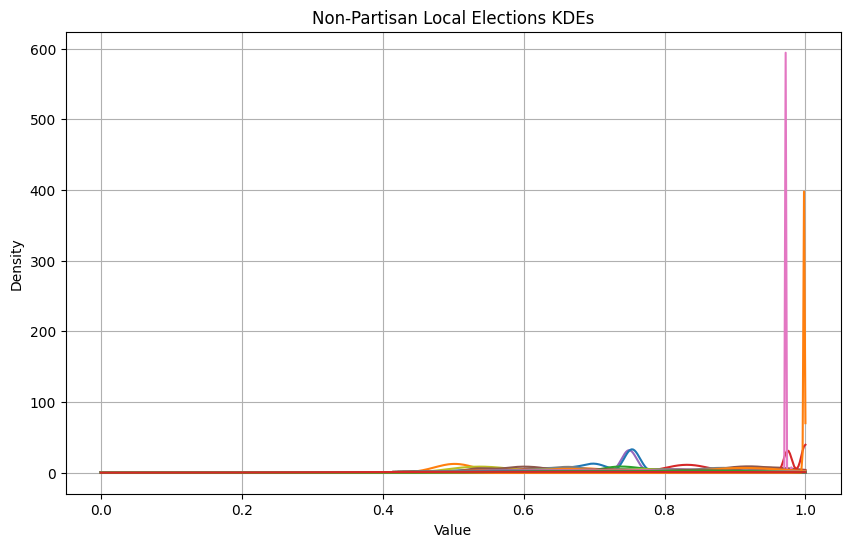

Computing KDE for target election:


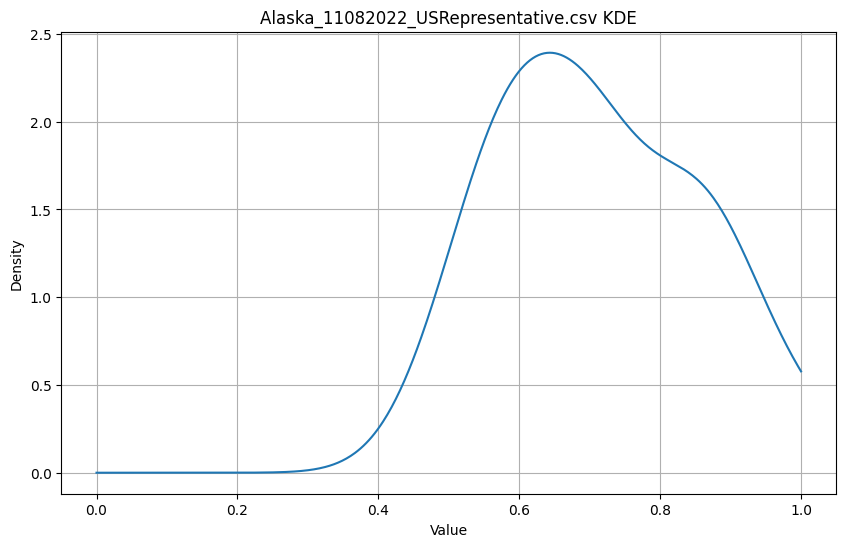

In [12]:
# Filter and compute KDE for STATE and FEDERAL level elections with YES in partisan
filter_criteria = {'level': ['FEDERAL', 'STATE'], 'partisan': 'YES'}
state_federal_points = filter_elections(filter_criteria)
print("Computing KDE for STATE and FEDERAL level elections with YES in partisan:")
kdes, x_grid = compute_kdes(state_federal_points)
plot_kdes(kdes, x_grid, "Partisan State and Federal Elections KDEs")

# Filter and compute KDE for LOCAL elections with NO in partisan
filter_criteria = {'level': 'LOCAL', 'partisan': 'NO'}
local_points = filter_elections(filter_criteria)
print("Computing KDE for LOCAL elections with NO in partisan:")
kdes, x_grid = compute_kdes(local_points)
plot_kdes(kdes, x_grid, "Non-Partisan Local Elections KDEs")

# Compute and plot KDE for a single election
print("Computing KDE for target election:")
kdes, x_grid = compute_kdes([election_consistency_points["Alaska_11082022_USRepresentative.csv"]])
plot_kdes(kdes, x_grid, "Alaska_11082022_USRepresentative.csv KDE")

In [78]:
def mirror_and_normalize(points):
    # 1. Determine the x-axis midpoint
    midpoint = (max(points.keys()) + min(points.keys())) / 2

    # 2. Create a mirrored version of the dataset
    mirrored_points = {midpoint + (midpoint - k): v for k, v in points.items()}

    # 3. Combine the original and mirrored dataset
    combined = {}
    for k, v in points.items():
        combined[k] = v + mirrored_points.get(k, 0)
    for k, v in mirrored_points.items():
        combined[k] = v + points.get(k, 0)

    # 4. Normalize the x-values
    min_x = min(combined.keys())
    max_x = max(combined.keys())
    x_range = max_x - min_x
    combined = {(k - min_x) / x_range: v for k, v in combined.items()}

    # 5. Normalize the y-values
    total_y = sum(combined.values())
    normalized = {k: v / total_y for k, v in combined.items()}

    return normalized

def average_datasets(points_list):
    normalized_list = [mirror_and_normalize(points) for points in points_list]

    # A dictionary to store the sum of y-values for each x-value
    y_sum = {}
    # A dictionary to store the count of y-values for each x-value
    y_count = {}

    for normalized_points in normalized_list:
        for k, v in normalized_points.items():
            if k in y_sum:
                y_sum[k] += v
                y_count[k] += 1
            else:
                y_sum[k] = v
                y_count[k] = 1

    # Compute the average y-value for each x-value
    averaged = {k: y_sum[k] / y_count[k] for k in y_sum.keys()}
    
    # Normalize the peak magnitude to 1
    max_y_value = max(averaged.values())
    normalized_averaged = {k: v / max_y_value for k, v in averaged.items()}

    return normalized_averaged

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

def average_and_plot(points_list, title="Averaged Data Analysis"):
    
    # Use the mirror_and_normalize function to handle the mirroring and normalization
    normalized_points_list = [mirror_and_normalize(points) for points in points_list]

    # Average across the normalized dictionaries
    averaged_points = {}
    for normalized_points in normalized_points_list:
        for k, v in normalized_points.items():
            if k in averaged_points:
                averaged_points[k] += v
            else:
                averaged_points[k] = v

    num_dicts = len(normalized_points_list)
    averaged_points = {k: v / num_dicts for k, v in averaged_points.items()}

    # Extract data for histogram and KDE
    data_list = [x for x, count in averaged_points.items() for _ in range(int(count * 100000))]  # Scale the values for visualization

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data_list, bins=50, density=True, alpha=0.7)
    plt.title(f"{title} - Histogram")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

    # Plot kernal density estimation
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data_list, fill=True)
    plt.title(f"{title} - Kernel Density Estimation")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

def average_and_plot(points_list, title="Averaged Data Analysis"):
    
    # Normalize and scale the dictionaries individually
    normalized_points_list = []
    for points in points_list:
        
        # Determine the absolute max x-value for symmetric normalization for this set of points
        abs_max_x = max(abs(min(points.keys())), abs(max(points.keys())))
        
        # Symmetrically normalize x-values
        normalized_x = {x: (x + abs_max_x) / (2 * abs_max_x) for x in points.keys()}
        
        # Find the peak y-value (highest frequency)
        max_y = max(points.values())
        
        # Scale y-values so the peak is 1
        scaled_y = {k: v / max_y for k, v in points.items()}
        
        # Create normalized dataset
        normalized_points = {normalized_x[k]: scaled_y[k] for k in points.keys()}
        normalized_points_list.append(normalized_points)

    # Average across the normalized dictionaries
    averaged_points = {}
    counts = {}  # To store counts for averaging

    for normalized_points in normalized_points_list:
        for k, v in normalized_points.items():
            if k in averaged_points:
                averaged_points[k] += v
                counts[k] += 1
            else:
                averaged_points[k] = v
                counts[k] = 1

    # Now divide the summed y-values by their counts to get the average
    averaged_points = {k: averaged_points[k] / counts[k] for k in averaged_points.keys()}

    # Extract data for histogram and KDE
    data_list = [x for x, count in averaged_points.items() for _ in range(int(count * 100000))]  # Scale the values for visualization

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data_list, bins=50, density=True, alpha=0.7)
    plt.title(f"{title} - Histogram")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

    # Plot kernal density estimation
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data_list, fill=True)
    plt.title(f"{title} - Kernel Density Estimation")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

Alaska_08162022_HouseofRepresentativesSpecial.csv
Alaska_11082022_USRepresentative.csv
Maine_11062018_CongressionalDistrict2.csv
Maine_11082022_CongressionalDistrict2.csv
Alaska_11082022_USSenator.csv
Alaska_11082022_GovernorLieutenantGovernor.csv
Alaska_11082022_HouseDistrict1.csv
Alaska_11082022_HouseDistrict2.csv
Alaska_11082022_HouseDistrict4.csv
Alaska_11082022_HouseDistrict5.csv
Alaska_11082022_HouseDistrict6.csv
Alaska_11082022_HouseDistrict7.csv
Alaska_11082022_HouseDistrict9.csv
Alaska_11082022_HouseDistrict10.csv
Alaska_11082022_HouseDistrict11.csv
Alaska_11082022_HouseDistrict12.csv
Alaska_11082022_HouseDistrict13.csv
Alaska_11082022_HouseDistrict14.csv
Alaska_11082022_HouseDistrict15.csv
Alaska_11082022_HouseDistrict16.csv
Alaska_11082022_HouseDistrict17.csv
Alaska_11082022_HouseDistrict18.csv
Alaska_11082022_HouseDistrict19.csv
Alaska_11082022_HouseDistrict20.csv
Alaska_11082022_HouseDistrict21.csv
Alaska_11082022_HouseDistrict22.csv
Alaska_11082022_HouseDistrict23.csv
Ala

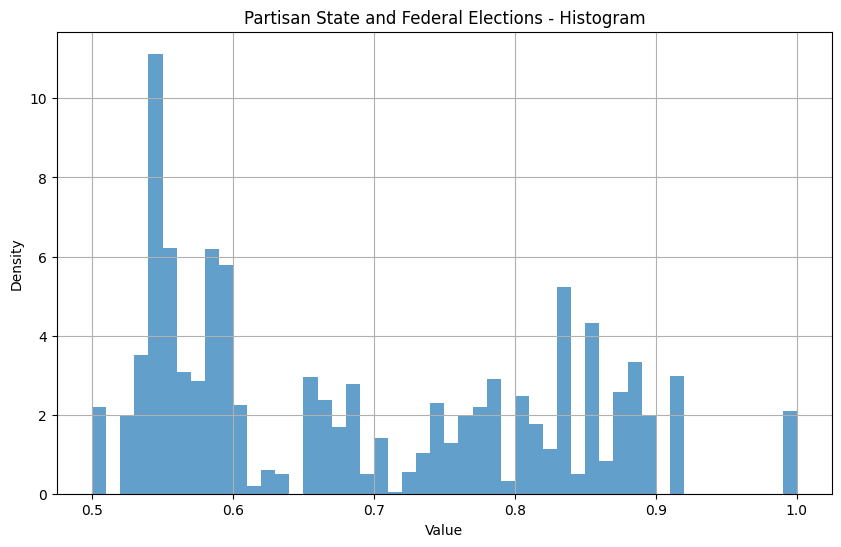

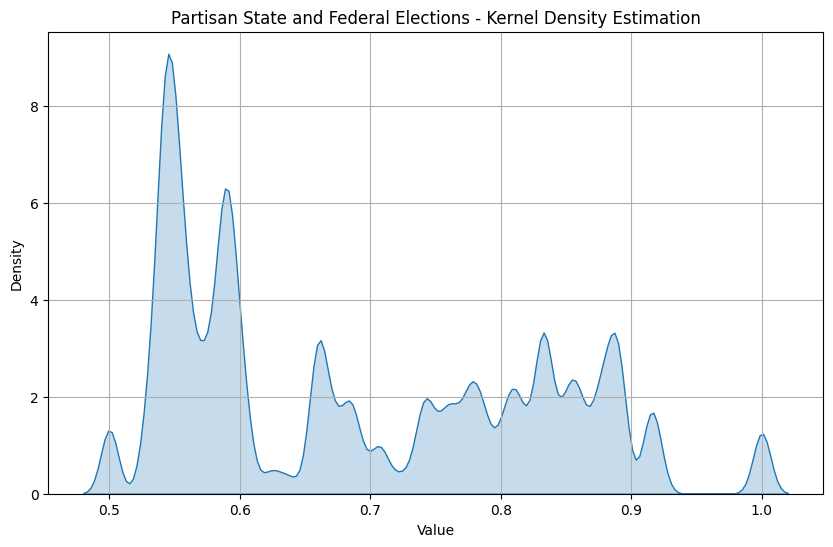

Albany_11082022_BoardofEducation.csv
Minneapolis_11022021_ParkBoardAtLarge.csv
Minneapolis_11022021_ParkBoardDistrict2.csv
Minneapolis_11022021_ParkBoardDistrict3.csv
Minneapolis_11022021_ParkBoardDistrict4.csv
Minneapolis_11022021_ParkBoardDistrict5.csv
Minneapolis_11022021_ParkBoardDistrict6.csv
Minneapolis_11052013_PRBoardDistrict2.csv
Minneapolis_11052013_PRBoardDistrict6.csv
Minneapolis_11062009_PRBoardDistrict1.csv
Minneapolis_11062009_PRBoardDistrict2.csv
Minneapolis_11062009_PRBoardDistrict3.csv
Minneapolis_11062009_PRBoardDistrict5.csv
Minneapolis_11062009_PRBoardDistrict6.csv
Minneapolis_11072017_PRBoardDistrict1.csv
Minneapolis_11072017_PRBoardDistrict2.csv
Minneapolis_11072017_PRBoardDistrict3.csv
Minneapolis_11072017_PRBoardDistrict4.csv
Minneapolis_11072017_PRBoardDistrict5.csv
Minneapolis_11072017_PRBoardDistrict6.csv
Oakland_11022010_SchoolDirectorDistrict4.csv
Oakland_11032020_SchoolDirectorDist1OaklandRCV.csv
Oakland_11032020_SchoolDirectorDist3OaklandRCV.csv
Oakland_

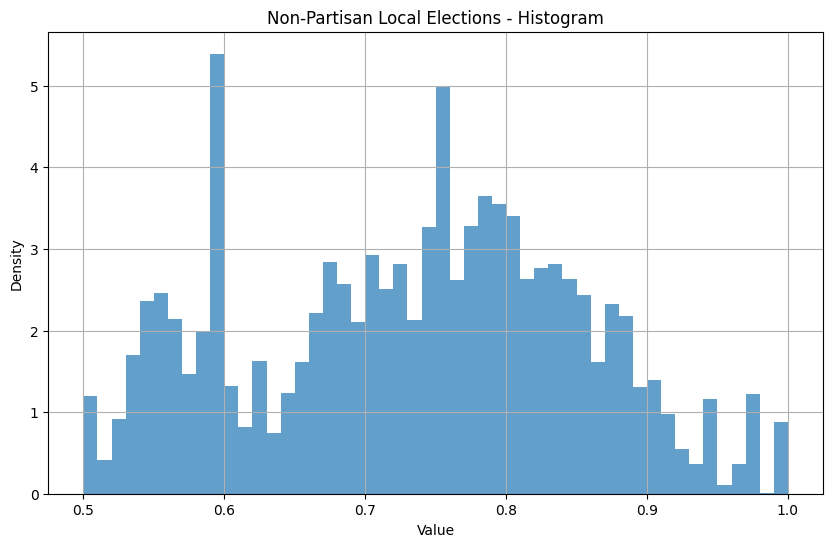

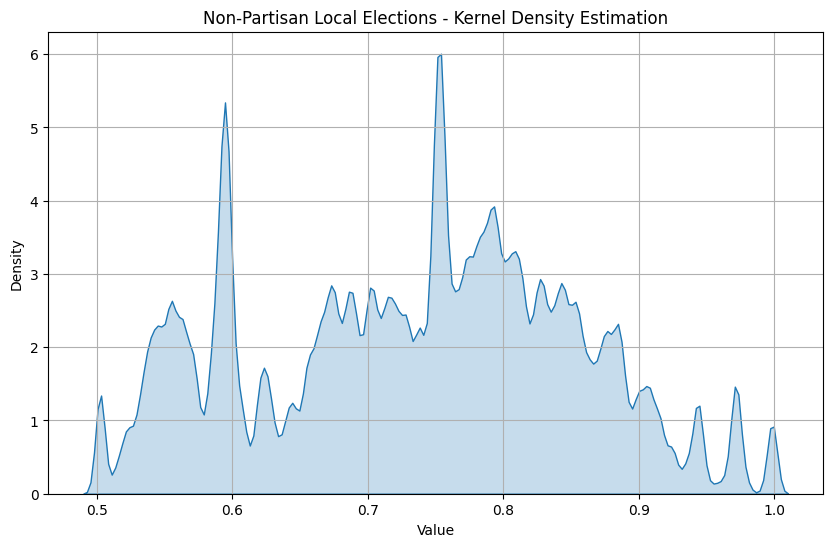

Testing for target election:


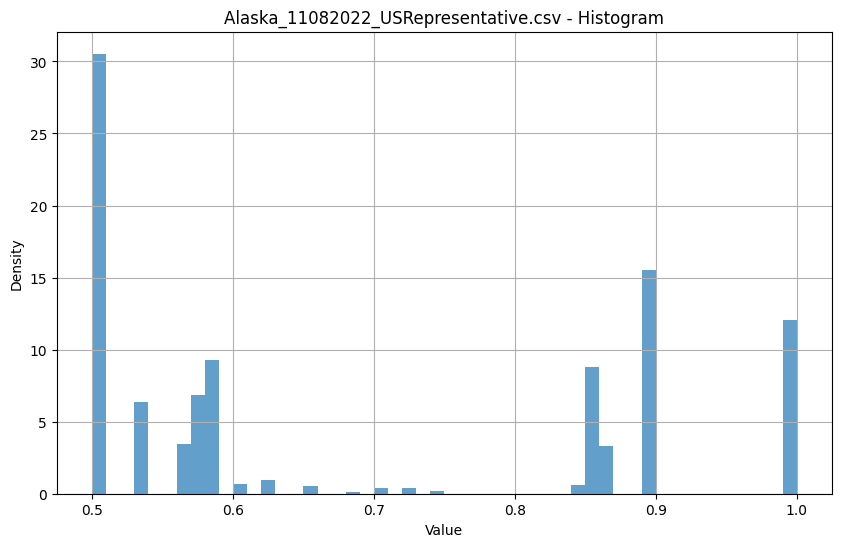

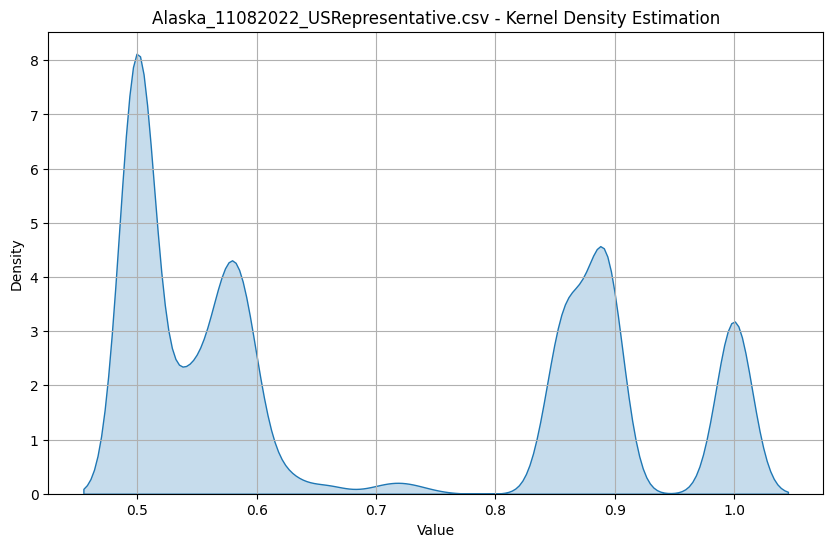

In [84]:
# Filter and average for STATE and FEDERAL level elections with YES in partisan
filter_criteria = {'level': ['FEDERAL', 'STATE'], 'partisan': 'YES'}
state_federal_points = filter_elections(filter_criteria)
print("(Method 1) Averaging for STATE and FEDERAL level elections with YES in partisan:")
average_and_plot(state_federal_points, "Partisan State and Federal Elections")

# Filter and average for LOCAL elections with NO in partisan
filter_criteria = {'level': 'LOCAL', 'partisan': 'NO'}
local_points = filter_elections(filter_criteria)
print("(Method 1) Averaging for LOCAL elections with NO in partisan:")
average_and_plot(local_points, "Non-Partisan Local Elections")

# Testing for a single election
print("Testing for target election:")
average_and_plot([election_consistency_points["Alaska_11082022_USRepresentative.csv"]], "Alaska_11082022_USRepresentative.csv")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import numpy as np

def average_and_plot(points_list, title="Averaged Data Analysis"):
    
    # Grid for KDE evaluation
    x_grid = np.linspace(0, 1, 500)
    kde_values_list = []
    
    # Normalize, scale and compute KDE for each election
    for points in points_list:
        # Normalize x-values
        abs_max_x = max(abs(min(points.keys())), abs(max(points.keys())))
        normalized_data = [(x + abs_max_x) / (2 * abs_max_x) for x in points.keys()]
        
        # Scale y-values
        max_y = max(points.values())
        scaled_weights = [v / max_y for v in points.values()]
        
        # Compute KDE values
        kde = gaussian_kde(normalized_data, weights=scaled_weights)
        kde_values_list.append(kde(x_grid))
    
    # Average the KDE values across all elections
    avg_kde = np.mean(kde_values_list, axis=0)
    
    # Plot the averaged KDE
    plt.figure(figsize=(10, 6))
    plt.plot(x_grid, avg_kde)
    plt.title(f"{title} - Kernel Density Estimation")
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

Alaska_08162022_HouseofRepresentativesSpecial.csv
Alaska_11082022_USRepresentative.csv
Maine_11062018_CongressionalDistrict2.csv
Maine_11082022_CongressionalDistrict2.csv
Alaska_11082022_USSenator.csv
Alaska_11082022_GovernorLieutenantGovernor.csv
Alaska_11082022_HouseDistrict1.csv
Alaska_11082022_HouseDistrict2.csv
Alaska_11082022_HouseDistrict4.csv
Alaska_11082022_HouseDistrict5.csv
Alaska_11082022_HouseDistrict6.csv
Alaska_11082022_HouseDistrict7.csv
Alaska_11082022_HouseDistrict9.csv
Alaska_11082022_HouseDistrict10.csv
Alaska_11082022_HouseDistrict11.csv
Alaska_11082022_HouseDistrict12.csv
Alaska_11082022_HouseDistrict13.csv
Alaska_11082022_HouseDistrict14.csv
Alaska_11082022_HouseDistrict15.csv
Alaska_11082022_HouseDistrict16.csv
Alaska_11082022_HouseDistrict17.csv
Alaska_11082022_HouseDistrict18.csv
Alaska_11082022_HouseDistrict19.csv
Alaska_11082022_HouseDistrict20.csv
Alaska_11082022_HouseDistrict21.csv
Alaska_11082022_HouseDistrict22.csv
Alaska_11082022_HouseDistrict23.csv
Ala

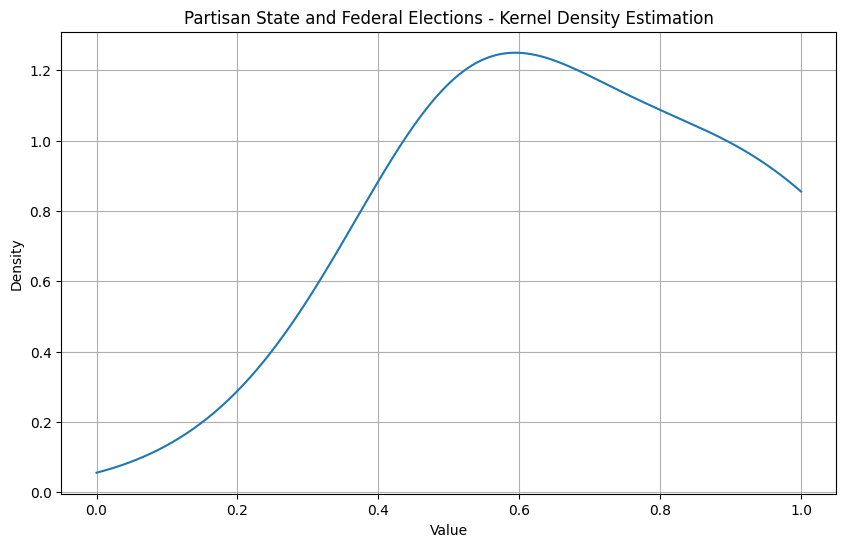

Albany_11082022_BoardofEducation.csv
Minneapolis_11022021_ParkBoardAtLarge.csv
Minneapolis_11022021_ParkBoardDistrict2.csv
Minneapolis_11022021_ParkBoardDistrict3.csv
Minneapolis_11022021_ParkBoardDistrict4.csv
Minneapolis_11022021_ParkBoardDistrict5.csv
Minneapolis_11022021_ParkBoardDistrict6.csv
Minneapolis_11052013_PRBoardDistrict2.csv
Minneapolis_11052013_PRBoardDistrict6.csv
Minneapolis_11062009_PRBoardDistrict1.csv
Minneapolis_11062009_PRBoardDistrict2.csv
Minneapolis_11062009_PRBoardDistrict3.csv
Minneapolis_11062009_PRBoardDistrict5.csv
Minneapolis_11062009_PRBoardDistrict6.csv
Minneapolis_11072017_PRBoardDistrict1.csv
Minneapolis_11072017_PRBoardDistrict2.csv
Minneapolis_11072017_PRBoardDistrict3.csv
Minneapolis_11072017_PRBoardDistrict4.csv
Minneapolis_11072017_PRBoardDistrict5.csv
Minneapolis_11072017_PRBoardDistrict6.csv
Oakland_11022010_SchoolDirectorDistrict4.csv
Oakland_11032020_SchoolDirectorDist1OaklandRCV.csv
Oakland_11032020_SchoolDirectorDist3OaklandRCV.csv
Oakland_

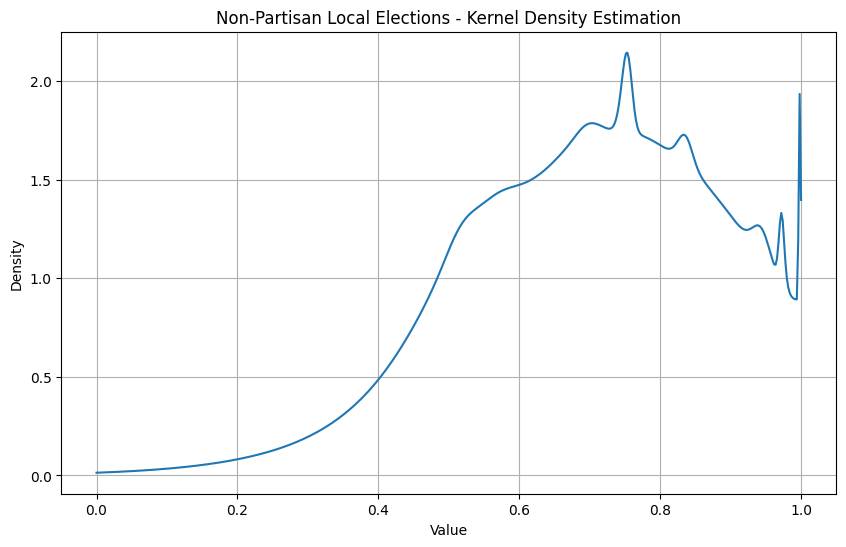

Testing for target election:


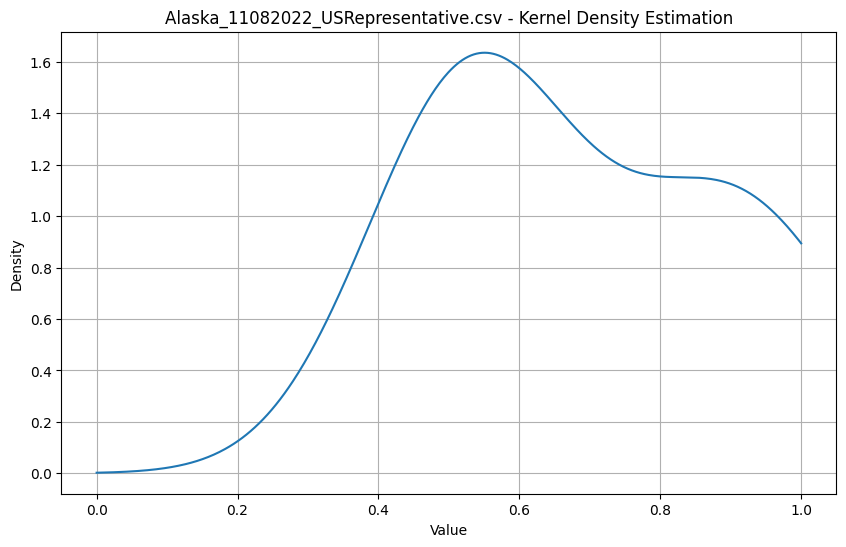

In [6]:
# Filter and average for STATE and FEDERAL level elections with YES in partisan
filter_criteria = {'level': ['FEDERAL', 'STATE'], 'partisan': 'YES'}
state_federal_points = filter_elections(filter_criteria)
print("(Method 1) Averaging for STATE and FEDERAL level elections with YES in partisan:")
average_and_plot(state_federal_points, "Partisan State and Federal Elections")

# Filter and average for LOCAL elections with NO in partisan
filter_criteria = {'level': 'LOCAL', 'partisan': 'NO'}
local_points = filter_elections(filter_criteria)
print("(Method 1) Averaging for LOCAL elections with NO in partisan:")
average_and_plot(local_points, "Non-Partisan Local Elections")

# Testing for a single election
print("Testing for target election:")
average_and_plot([election_consistency_points["Alaska_11082022_USRepresentative.csv"]], "Alaska_11082022_USRepresentative.csv")